# Read data

In [55]:
%matplotlib inline

import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib as plt

def lossfun(y_pre,y_test):
    a = 0.1
    s = np.exp(a*(y_test-y_pre))-a*(y_test-y_pre)-1
    return s.mean()

data = pd.read_csv('train_3_groups.txt',sep='\t')

ass = data.groupby('ASS_ASSIGNMENT')
domicile = ass.get_group('Domicile')
domicile = domicile[['DATE','CSPL_RECEIVED_CALLS']]
domicile.to_csv('domicile_tsa.txt',sep='\t',index=False)
data = pd.read_csv('domicile_tsa.txt',sep='\t')
print data.head()
print '\n Data Types:'
print data.dtypes

                      DATE  CSPL_RECEIVED_CALLS
0  2011-01-01 00:00:00.000                    0
1  2011-01-01 00:30:00.000                    0
2  2011-01-01 01:00:00.000                    0
3  2011-01-01 01:30:00.000                    0
4  2011-01-01 02:00:00.000                    0

 Data Types:
DATE                   object
CSPL_RECEIVED_CALLS     int64
dtype: object


# Time series of data

In [56]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S.%f')
data = pd.read_csv('domicile_tsa.txt',sep='\t', parse_dates=['DATE'], index_col='DATE',date_parser=dateparse)
print data.head()

                     CSPL_RECEIVED_CALLS
DATE                                    
2011-01-01 00:00:00                    0
2011-01-01 00:30:00                    0
2011-01-01 01:00:00                    0
2011-01-01 01:30:00                    0
2011-01-01 02:00:00                    0


In [57]:
ts = data['CSPL_RECEIVED_CALLS']
ts.head()

DATE
2011-01-01 00:00:00    0
2011-01-01 00:30:00    0
2011-01-01 01:00:00    0
2011-01-01 01:30:00    0
2011-01-01 02:00:00    0
Name: CSPL_RECEIVED_CALLS, dtype: int64

In [58]:
ts = ts.asfreq('30min')
ts = ts.fillna(0)

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
rcParams["text.usetex"] = False

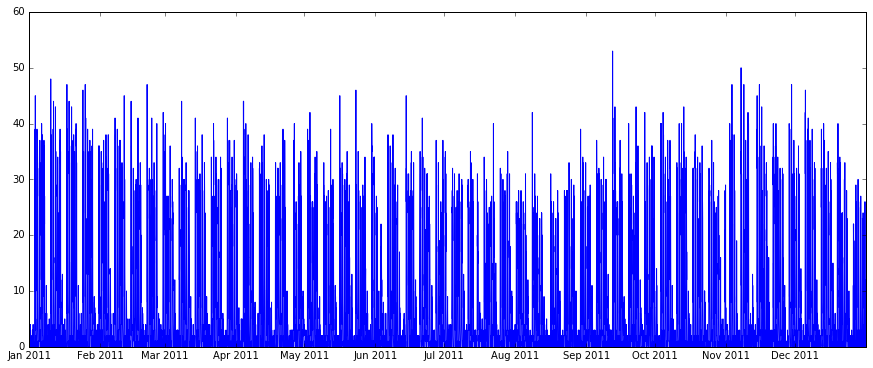

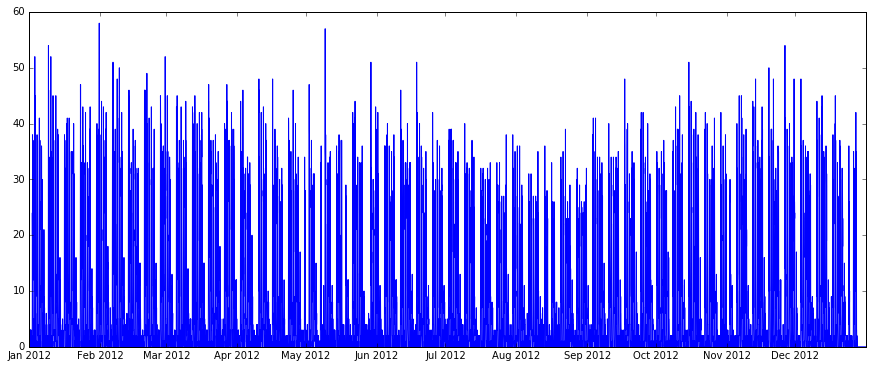

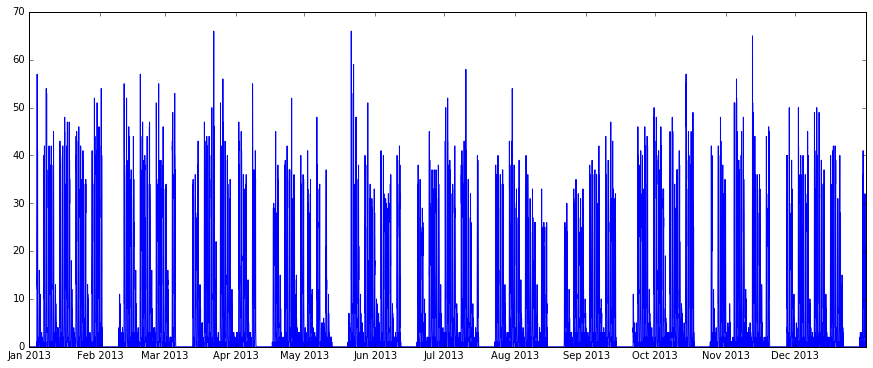

In [60]:
plt.figure()
plt.plot(ts['2011'])

plt.figure()
plt.plot(ts['2012'])

plt.figure()
plt.plot(ts['2013'])

# Make difference to reduce the tendence and seasonal influence

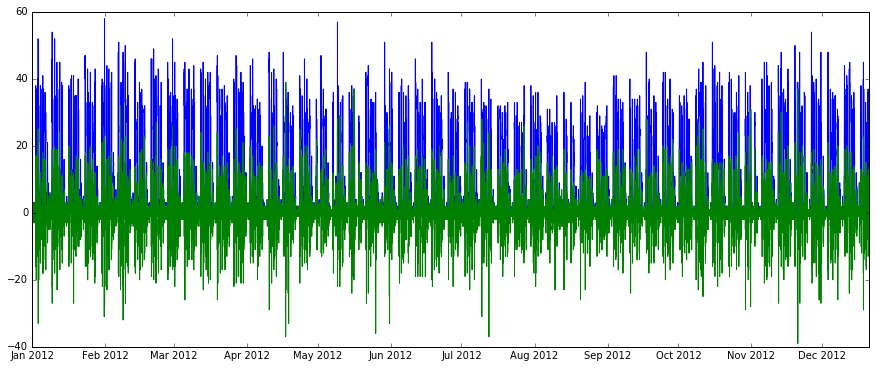

In [61]:
ts_data =  ts['2012-01-01':'2012-12-20']
ts_data_diff = ts_data - ts_data.shift()
plt.plot(ts_data)
plt.plot(ts_data_diff,'g')

In [62]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=48)
    rolstd = pd.rolling_std(timeseries, window=48)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=48,center=False).mean()
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=48,center=False).std()


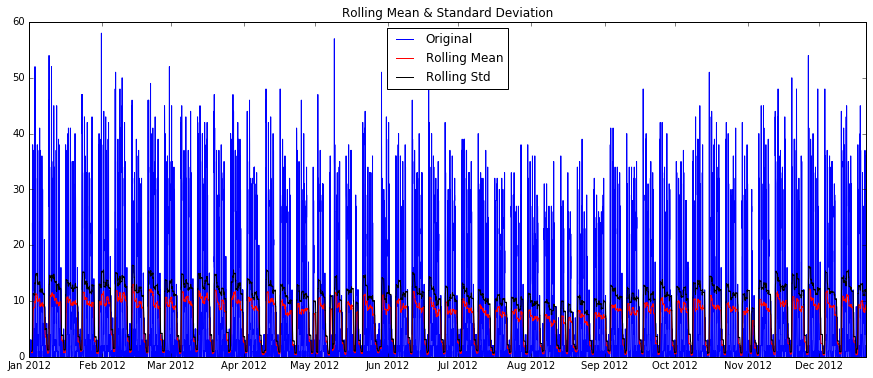

Results of Dickey-Fuller Test:
Test Statistic                -1.069511e+01
p-value                        3.641537e-19
#Lags Used                     4.400000e+01
Number of Observations Used    1.699500e+04
Critical Value (5%)           -2.861710e+00
Critical Value (1%)           -3.430735e+00
Critical Value (10%)          -2.566861e+00
dtype: float64


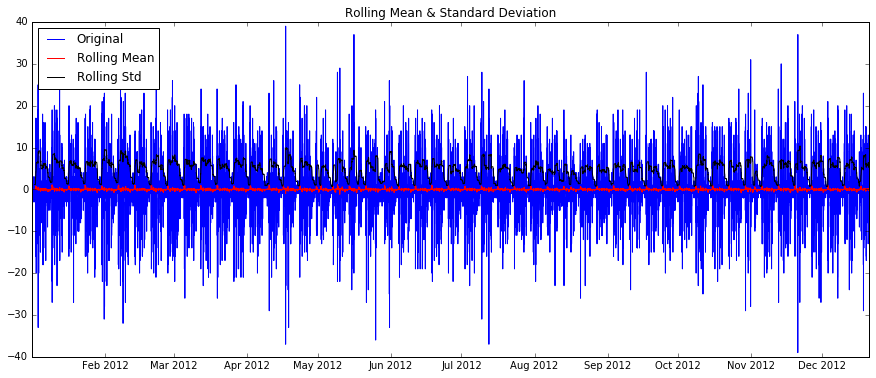

Results of Dickey-Fuller Test:
Test Statistic                   -57.453530
p-value                            0.000000
#Lags Used                        44.000000
Number of Observations Used    16994.000000
Critical Value (5%)               -2.861710
Critical Value (1%)               -3.430735
Critical Value (10%)              -2.566861
dtype: float64


In [63]:
ts_data_diff.dropna(inplace=True)

test_stationarity(ts_data)
test_stationarity(ts_data_diff)

# Autocorrelation function (ACF) & Partially autocorrelation function(PACF)

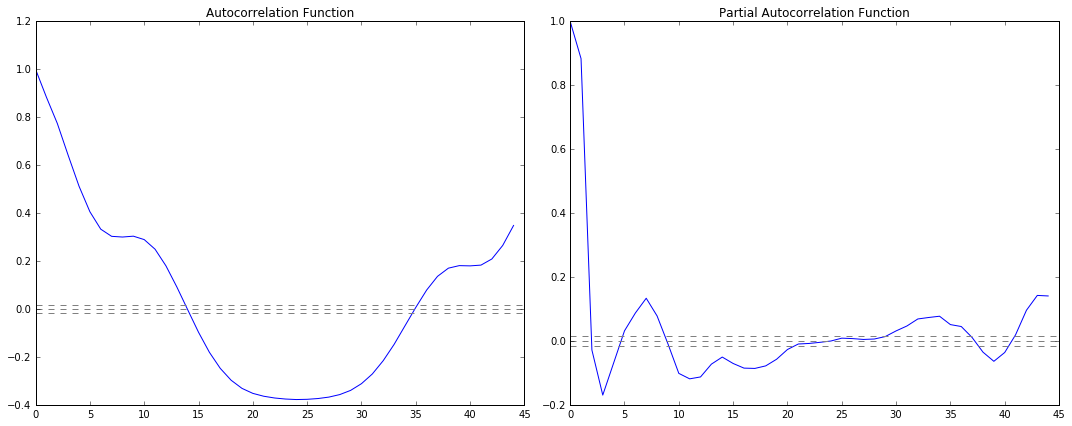

In [64]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_data, nlags=44)
lag_pacf = pacf(ts_data, nlags=44, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_data_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_data_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_data_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_data_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

We can get the parameters for Autocorrelation integrated moving average (ARIMA) model.<br/>
p = 2,from figure 1<br/>
q = 2, from figure

# Autocorrelation (AR) model

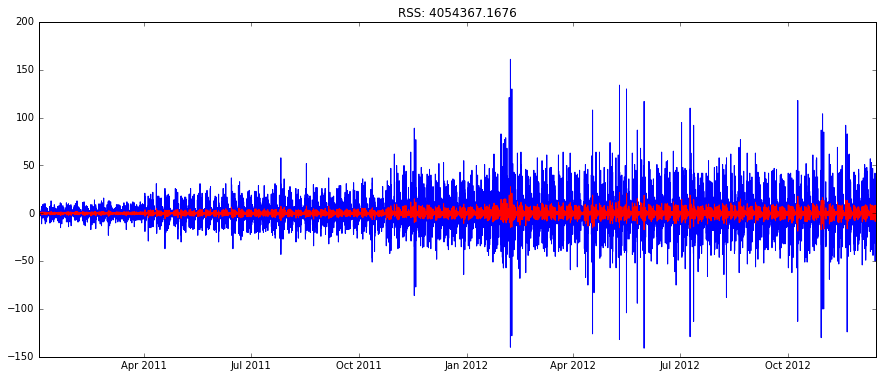

In [15]:
from statsmodels.tsa.arima_model import ARIMA

ts_data = ts_data.astype(float)
model = ARIMA(ts_data, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_data_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_data_diff)**2))

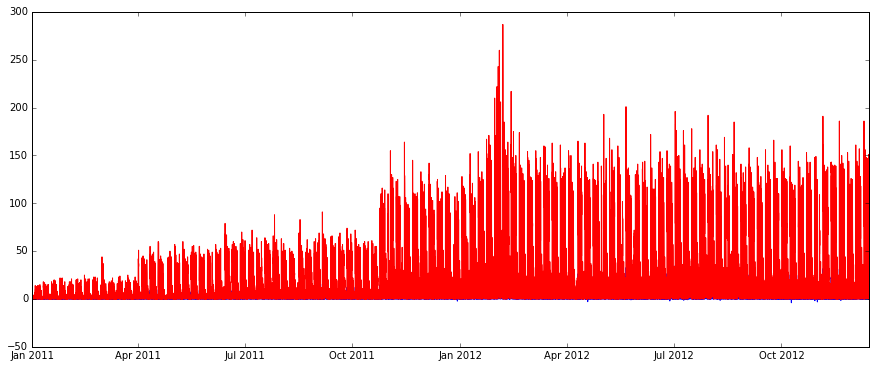

In [172]:
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
predictions_AR = pd.Series(ts_data.ix[0], index=ts_data.index)
predictions_AR = predictions_AR.add(predictions_AR_diff_cumsum,fill_value=0)
predictions_AR = (predictions_AR)
plt.plot(predictions_AR)
plt.plot(ts_data, color='red')


In [ ]:
def lossfun(y_pre,y_test):
    a = 0.1
    s = np.exp(a*(y_test-y_pre))-a*(y_test-y_pre)-1
    return s.mean()

In [178]:
print lossfun(predictions_AR, ts[:'2012-12-14'])
print len(ts[:'2012-12-14'])

11187646.755
34272


5945787.88887


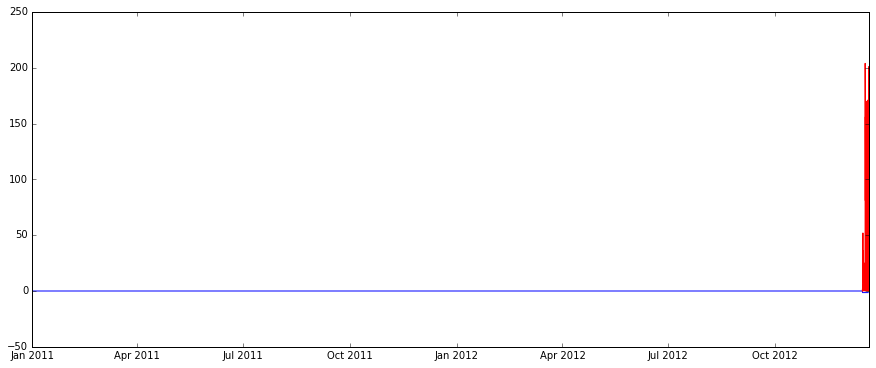

In [188]:
predictions = results_AR.predict('2012-12-15','2012-12-20')
predictions_AR_diff = pd.Series(predictions, copy=True)
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
predictions_AR = pd.Series(ts_data.ix[0], index=ts_data.index)
predictions_AR = predictions_AR.add(predictions_AR_diff_cumsum,fill_value=0)
predictions = (predictions_AR)

print lossfun(predictions, ts['2012-12-15':'2012-12-20'])
plt.plot(predictions)
plt.plot(ts['2012-12-15':'2012-12-20'], color='red')

# Moving average(MA) model

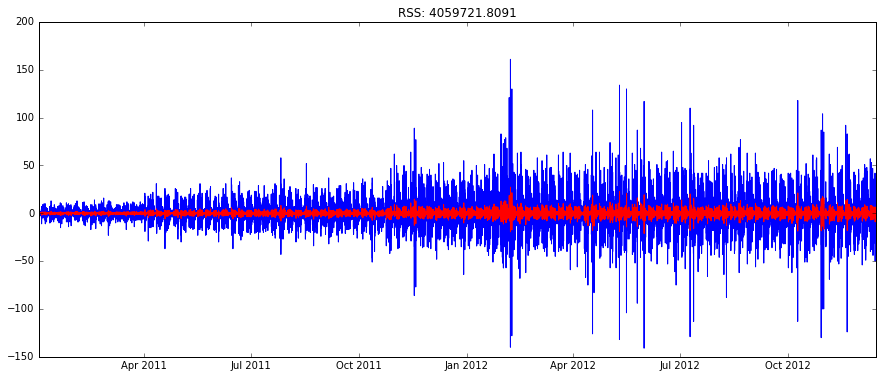

In [16]:
ts_data = ts_data.astype(float)
model = ARIMA(ts_data, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_data_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_data_diff)**2))

In [ ]:
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()
predictions_MA = pd.Series(ts_data.ix[0], index=ts_data.index)
predictions_MA = predictions_MA.add(predictions_MA_diff_cumsum,fill_value=0)
predictions_MA = (predictions_MA)

print lossfun(predictions_MA, ts['2011':'2012'])

# Combined model(ARIMA)

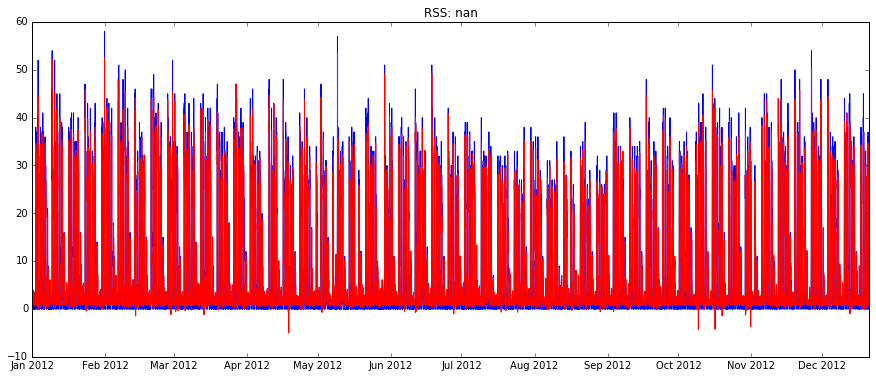

In [99]:
from statsmodels.tsa.arima_model import ARIMA

ts_data = ts_data.astype(float)
model = ARIMA(ts_data, order=(2, 0, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_data)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_data_diff)**2))

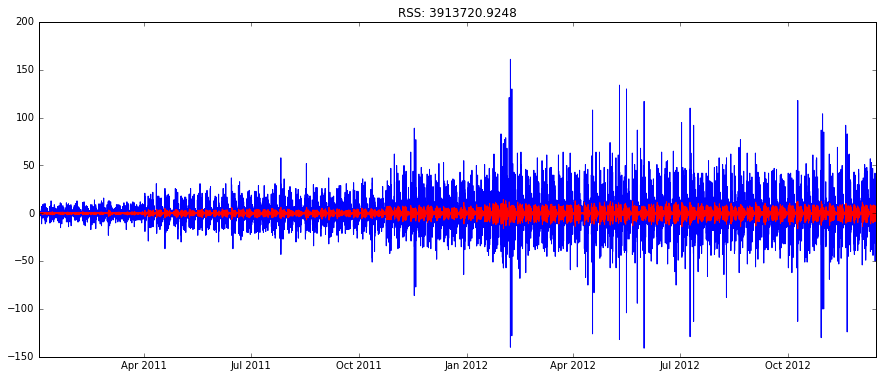

In [18]:
plt.plot(ts_data_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_data_diff)**2))

In [10]:
def lossfun(y_pre,y_test):
    a = 0.1
    s = np.exp(a*(y_test-y_pre))-a*(y_test-y_pre)-1
    return s.mean()

In [67]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_data = pd.Series(ts_data.ix[0], index=ts_data.index)
predictions_ARIMA_data = predictions_ARIMA_data.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = (predictions_ARIMA_data)

print lossfun(predictions_ARIMA, ts[:'2012-12-20'])

7158529.50836


In [100]:
print lossfun(results_ARIMA.fittedvalues, ts['2012-01-01':'2012-12-20'])
print results_ARIMA.fittedvalues

0.166447497171
DATE
2012-01-01 00:00:00     6.768285
2012-01-01 00:30:00     0.794546
2012-01-01 01:00:00     0.811664
2012-01-01 01:30:00     0.969728
2012-01-01 02:00:00     1.050360
2012-01-01 02:30:00     1.044964
2012-01-01 03:00:00     1.023438
2012-01-01 03:30:00     1.015105
2012-01-01 04:00:00     1.015987
2012-01-01 04:30:00     1.018205
2012-01-01 05:00:00     1.019011
2012-01-01 05:30:00     1.018884
2012-01-01 06:00:00     1.900041
2012-01-01 06:30:00     1.187981
2012-01-01 07:00:00     0.900869
2012-01-01 07:30:00     0.928351
2012-01-01 08:00:00     1.885294
2012-01-01 08:30:00     1.201267
2012-01-01 09:00:00     0.910094
2012-01-01 09:30:00     0.929579
2012-01-01 10:00:00     1.883816
2012-01-01 10:30:00     2.963114
2012-01-01 11:00:00     3.892990
2012-01-01 11:30:00     1.202530
2012-01-01 12:00:00     1.350229
2012-01-01 12:30:00     1.781508
2012-01-01 13:00:00     1.061716
2012-01-01 13:30:00     3.514301
2012-01-01 14:00:00     3.213311
2012-01-01 14:30:00    

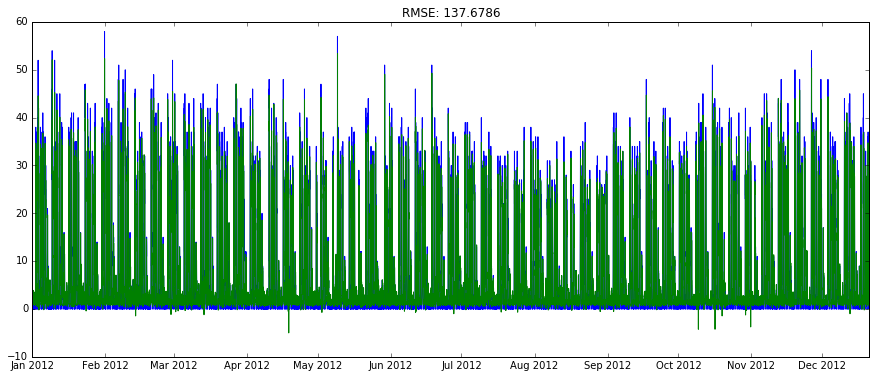

In [101]:
plt.plot(ts_data)
plt.plot(results_ARIMA.fittedvalues)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_data)**2)/len(ts)))

## Prediction 

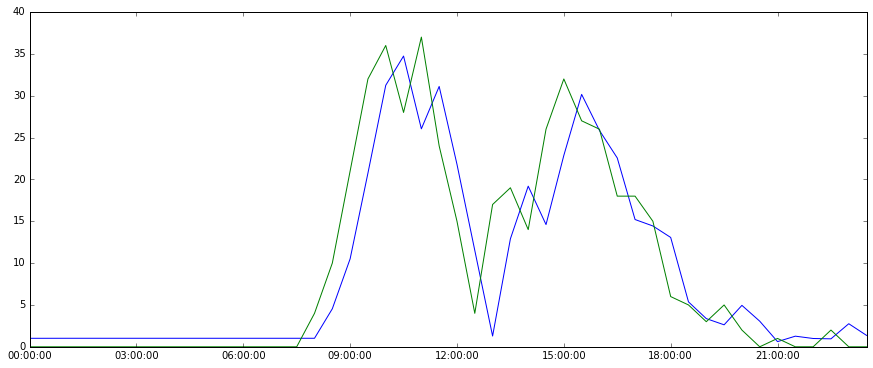

In [113]:
predictions = results_ARIMA.predict(start='2012-12-20 00:00:00.00',end='2012-12-20 23:30:00.00')
plt.plot(predictions)
plt.plot(ts['2012-12-20'])